In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
# IMAGES_PATH = "./data/train2017/train2017"  # Directory with training images
# VAL_IMAGES_PATH = "./data/val2017/val2017"  # Directory with validation images
# CAPTIONS_PATH = "./data/annotations_trainval2017/annotations/captions_train2017.json"  # Caption file
# VAL_CAPTIONS_PATH = "./data/annotations_trainval2017/annotations/captions_val2017.json"  # Validation caption file

IMAGES_PATH = "../phase_1/data/flickr8k/images"  # Directory with training images
CAPTIONS_PATH = "../phase_1/data/flickr8k/captions.txt"  # Caption file
TEST_IMAGES_PATH = "./test/"  # Directory with test images

In [3]:
# from pycocotools.coco import COCO
# coco = COCO(CAPTIONS_PATH)

# print(len(list(coco.anns.keys())))  # Total number of annotations
# print("Num images:", len(coco.getImgIds()))
# print("Num captions:", len(coco.getAnnIds()))

In [4]:
import tqdm
import nltk 
from collections import Counter
from vocabulary_class import Vocabulary
nltk.download('punkt_tab')
import json

tokens = []
counter = Counter()

import csv

def build_vocab(json_path, threshold=5, limit=None):
    
    counter = Counter()
    image_captions = {}
    count =0
    with open(CAPTIONS_PATH, "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)  # skip header: image,caption

        for row in reader:
            if len(row) < 2:
                continue
            img_name, caption = row
            if img_name not in image_captions:
                    image_captions[img_name] = []
            image_captions[img_name].append(caption)

            caption = caption.lower()
            tokens = nltk.tokenize.word_tokenize(caption)
            counter.update(tokens)
            count +=1
            if limit and count >= limit:
                break
    
    vocab = Vocabulary()
    for word, cnt in counter.items():
        if cnt >= threshold:
            vocab.add_word(word)
    
    return vocab, image_captions

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
vocab, image_captions = build_vocab(CAPTIONS_PATH, threshold=5)
print("Total vocabulary size:", len(vocab))

Total vocabulary size: 3005


In [6]:
len(image_captions)

8091

In [7]:
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

In [8]:

from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch):
    images, captions = zip(*batch)

    images = torch.stack(images, 0)

    lengths = torch.tensor([len(c) for c in captions])

    captions = pad_sequence(
        captions,
        batch_first=True,
        padding_value=0
    )

    return images, captions, lengths

In [9]:
from torch.utils.data import DataLoader
from flickr_dataset import FlickrDataset 

train_dataset = FlickrDataset(
    root=IMAGES_PATH,
    captions_path=CAPTIONS_PATH,
    vocab=vocab,
    transform=transform,
    max_samples=None
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,
    collate_fn= collate_fn
)


In [10]:
print(len(train_dataset))

8091


In [11]:
image, caption = train_dataset[0]

print(type(image))
print(image.shape)        # after transform
print(caption)
print(len(caption))

<class 'torch.Tensor'>
torch.Size([3, 224, 224])
tensor([ 1,  3, 23, 18, 10, 20,  4, 21, 24, 17,  2])
11


In [12]:
from model import AttentionEncoderCNN, AttentionDecoderRNN
import torch.nn as nn

encoder = AttentionEncoderCNN(embed_size=256).to(device)
decoder = AttentionDecoderRNN(embed_size=256, hidden_size=512, vocab_size=len(vocab), encoder_dim=2048, attention_dim=512).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx["<pad>"])

params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)


d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:

for epoch in range(10):
    for images, captions, lengths in tqdm.tqdm(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        optimizer.zero_grad()
        
        features = encoder(images)
        outputs, alphas = decoder(features, captions, lengths)   # <-- IMPORTANT
        targets = captions[:, 1:]                       # shift left
        loss = criterion(
            outputs.reshape(-1, outputs.size(-1)),
            targets.reshape(-1)
        )

        
        loss.backward()
        optimizer.step()

    print("Epoch:", epoch, "Loss:", loss.item())

100%|██████████| 253/253 [00:33<00:00,  7.57it/s]


Epoch: 0 Loss: 3.4070286750793457


100%|██████████| 253/253 [00:34<00:00,  7.25it/s]


Epoch: 1 Loss: 3.259003162384033


100%|██████████| 253/253 [00:38<00:00,  6.54it/s]


Epoch: 2 Loss: 2.941936492919922


100%|██████████| 253/253 [00:54<00:00,  4.66it/s]


Epoch: 3 Loss: 2.750293016433716


100%|██████████| 253/253 [00:48<00:00,  5.19it/s]


Epoch: 4 Loss: 2.8375048637390137


100%|██████████| 253/253 [00:34<00:00,  7.38it/s]


Epoch: 5 Loss: 2.8328216075897217


100%|██████████| 253/253 [00:34<00:00,  7.23it/s]


Epoch: 6 Loss: 2.7849042415618896


100%|██████████| 253/253 [00:34<00:00,  7.29it/s]


Epoch: 7 Loss: 2.641134023666382


100%|██████████| 253/253 [00:34<00:00,  7.34it/s]


Epoch: 8 Loss: 2.5342633724212646


100%|██████████| 253/253 [00:34<00:00,  7.36it/s]

Epoch: 9 Loss: 2.6164298057556152


In [16]:
# Bluen score caluclation
from nltk.translate.bleu_score import corpus_bleu
references = []
hypotheses = []
encoder.eval()
decoder.eval()
with torch.no_grad():
    for images, captions, lengths in tqdm.tqdm(train_loader):
        images = images.to(device)
        captions = captions.to(device)

        features = encoder(images)
        outputs, alphas = decoder(features, captions, lengths)   # <-- IMPORTANT

        _, predicted = outputs.max(2)  # [B, max_len]

        for i in range(captions.size(0)):
            ref = []
            for j in range(1, lengths[i]):  # remove <start> token
                ref.append(vocab.idx2word[captions[i][j].item()])
            references.append([ref])

            hyp = []
            for j in range(1, lengths[i]):  # remove <start> token
                hyp.append(vocab.idx2word[predicted[i][j-1].item()])
            hypotheses.append(hyp)
        
    bleu1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

print("blue scores:" )
print("BLEU-1:", bleu1)
print("BLEU-2:", bleu2)
print("BLEU-3:", bleu3)
print("BLEU-4:", bleu4)


100%|██████████| 253/253 [00:34<00:00,  7.37it/s]


blue scores:
BLEU-1: 0.49954921330450885
BLEU-2: 0.3190850976942389
BLEU-3: 0.1981118245303027
BLEU-4: 0.12057332219038479


In [ ]:
def generate_caption(image, encoder, decoder, vocab, max_len=20):
    encoder.eval()
    decoder.eval()

    device = next(decoder.parameters()).device

    # ---- Encode image ----
    image = image.unsqueeze(0).to(device)      # [1, 3, 224, 224]
    encoder_out = encoder(image)                # [1, 49, 2048]

    # ---- Init hidden state ----
    h, c = decoder.init_hidden_state(encoder_out)

    # ---- Start token ----
    word = torch.tensor([vocab('<start>')]).to(device)

    caption = []

    for _ in range(max_len):
        # ---- Word embedding ----
        embedding = decoder.embed(word)         # [1, embed_size]

        # ---- Attention ----
        context, _ = decoder.attention(encoder_out, h)  # [1, 2048]

        # ---- LSTMCell input ----
        lstm_input = torch.cat([embedding.squeeze(1), context], dim=1)

        h, c = decoder.lstm(lstm_input, (h, c))

        outputs = decoder.linear(h)
        predicted = outputs.argmax(dim=1)

        word_id = predicted.item()
        word = predicted

        if vocab.idx2word[word_id] == '<end>':
            break

        caption.append(vocab.idx2word[word_id])

    return ' '.join(caption)


In [19]:
# torch.save({
#     'encoder_state_dict': encoder.state_dict(),
#     'decoder_state_dict': decoder.state_dict(),
#     'vocab': vocab,
#     'embed_size': 256,
#     'hidden_size': 512
# }, 'model.pth')

torch.save(encoder.state_dict(), "models/encoder.pth")
torch.save(decoder.state_dict(), "models/decoder.pth")
torch.save(vocab, "models/vocab.pkl")

In [21]:
from vocabulary_class import Vocabulary
from model import AttentionEncoderCNN, AttentionDecoderRNN

vocab = torch.load("models/vocab.pkl", weights_only=False)
encoder = AttentionEncoderCNN(256).to(device)
decoder = AttentionDecoderRNN(
    256,
    512,
    len(vocab),
    encoder_dim=2048, attention_dim=512
).to(device)

encoder.load_state_dict(torch.load("models/encoder.pth", weights_only=True, map_location=device))
decoder.load_state_dict(torch.load("models/decoder.pth", weights_only=True, map_location=device))

d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\AIML\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.535425].


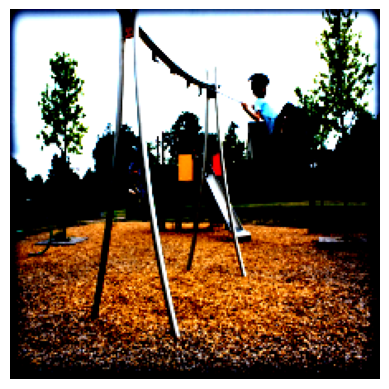

AttributeError: 'AttentionDecoderRNN' object has no attribute 'fc'

In [25]:
#  test the model on a few images
import os
import matplotlib.pyplot as plt
from PIL import Image

for file_name in os.listdir(TEST_IMAGES_PATH)[:20]:
    # Load image
    img_path = f"{TEST_IMAGES_PATH}/{file_name}"
    image = Image.open(img_path).convert("RGB")

    image = transform(image)
    plt.imshow(image.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()
    
    caption = generate_caption(image, encoder, decoder, vocab)
    print(f"Image: {file_name}\nCaption: {caption}\n")
